In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
  from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


In [11]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [14]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


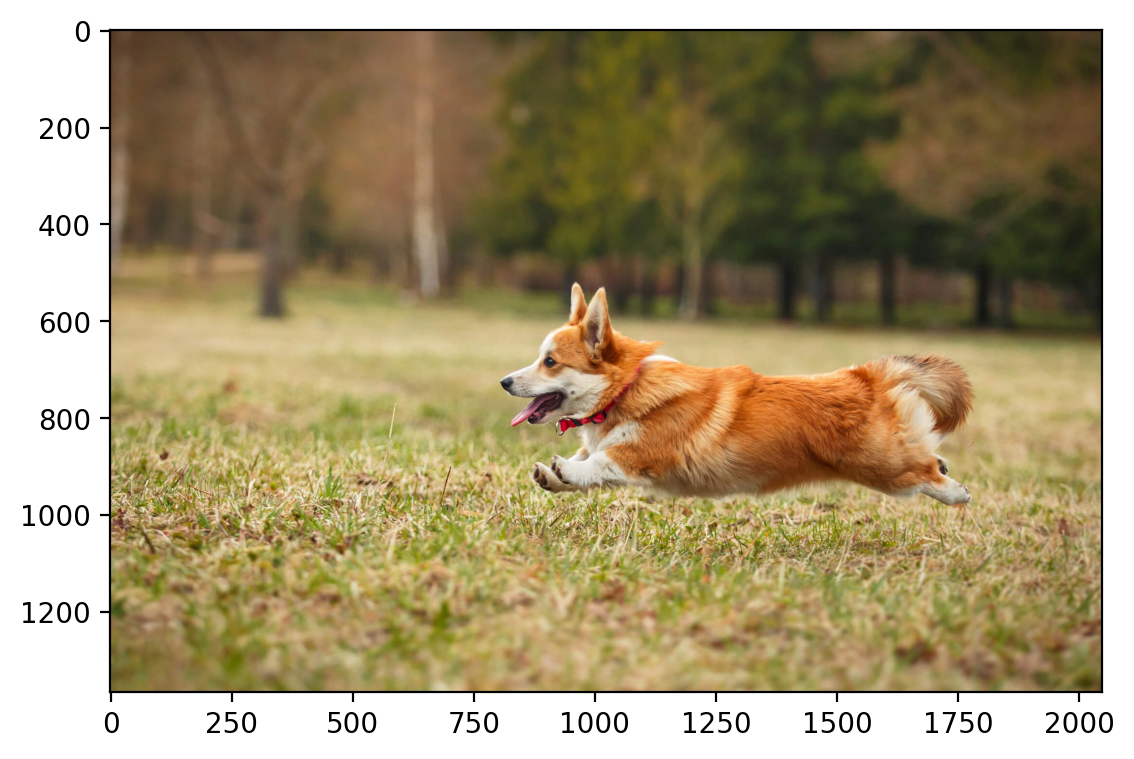

In [15]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [16]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img


MinMaxScaler()

In [17]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

(3, 1365, 2048)


In [18]:
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [19]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

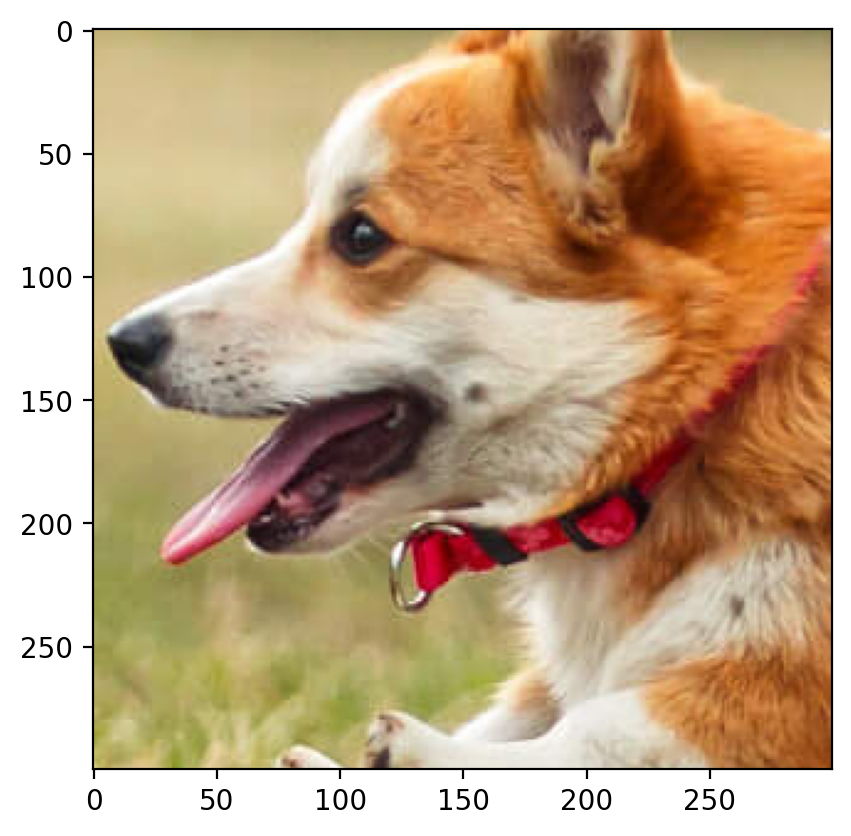

In [20]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [21]:
crop = crop.to(device)
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [22]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [23]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape
print(dog_X.shape)
print(dog_Y.shape)

torch.Size([90000, 2])
torch.Size([90000, 3])


In [24]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

dog_X_scaled = dog_X_scaled.float()

In [25]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [26]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [27]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [28]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler

    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [29]:
X_rff = create_rff_features(dog_X_scaled, 6000, 0.08)
X_rff.shape

torch.Size([90000, 6000])

In [33]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff, dog_Y, 1500)

Epoch 0 loss: 0.376431
Epoch 100 loss: 0.005386
Epoch 200 loss: 0.004738
Epoch 300 loss: 0.004543
Epoch 400 loss: 0.004423
Epoch 500 loss: 0.004342
Epoch 600 loss: 0.004286
Epoch 700 loss: 0.004247
Epoch 800 loss: 0.004218
Epoch 900 loss: 0.004196
Epoch 1000 loss: 0.004180
Epoch 1100 loss: 0.004167
Epoch 1200 loss: 0.004156
Epoch 1300 loss: 0.004148
Epoch 1400 loss: 0.004140


0.004133440554141998

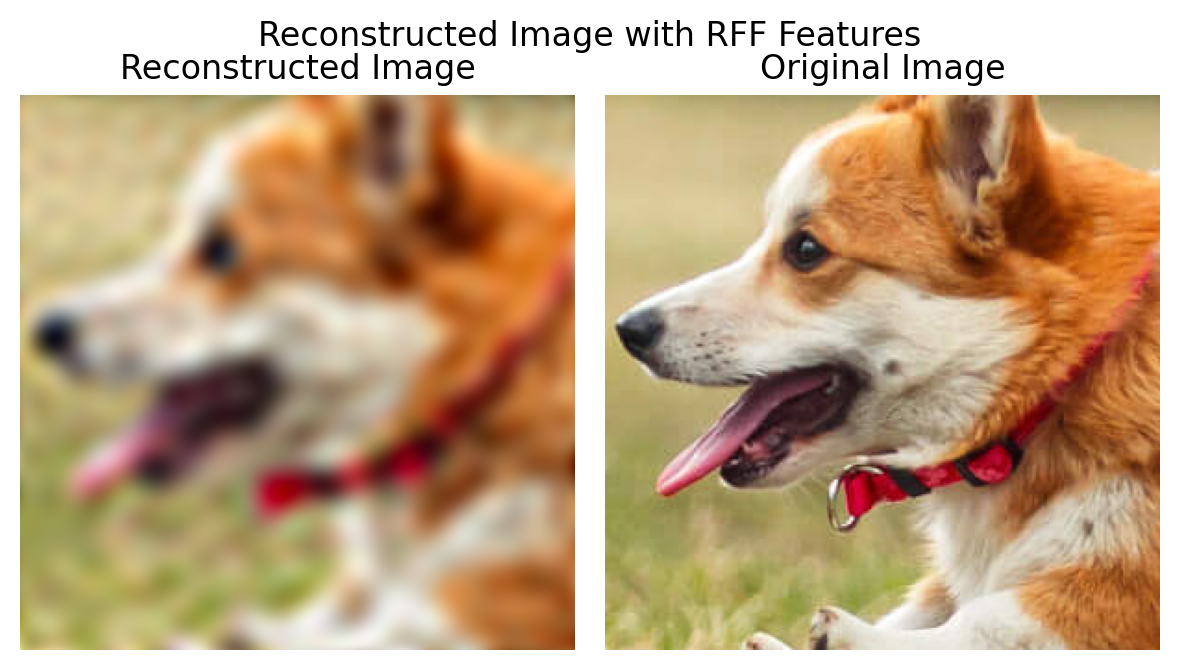

In [34]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")


In [35]:

def create_coordinate_map2(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (num_samples, 2) and torch.Tensor of shape (num_samples, num_channels)
    """

    num_channels, height, width = img.shape

    w_coords = torch.arange(0, width, 2).repeat(height // 2, 1)
    h_coords = torch.arange(0, height, 2).repeat(width // 2, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img[:, ::2, ::2], 'c h w -> (h w) c').float()
    return X, Y

In [36]:
dog_alt_X, dog_alt_Y = create_coordinate_map2(crop)
print(dog_alt_X.shape)
print(dog_alt_Y.shape)

torch.Size([22500, 2])
torch.Size([22500, 3])


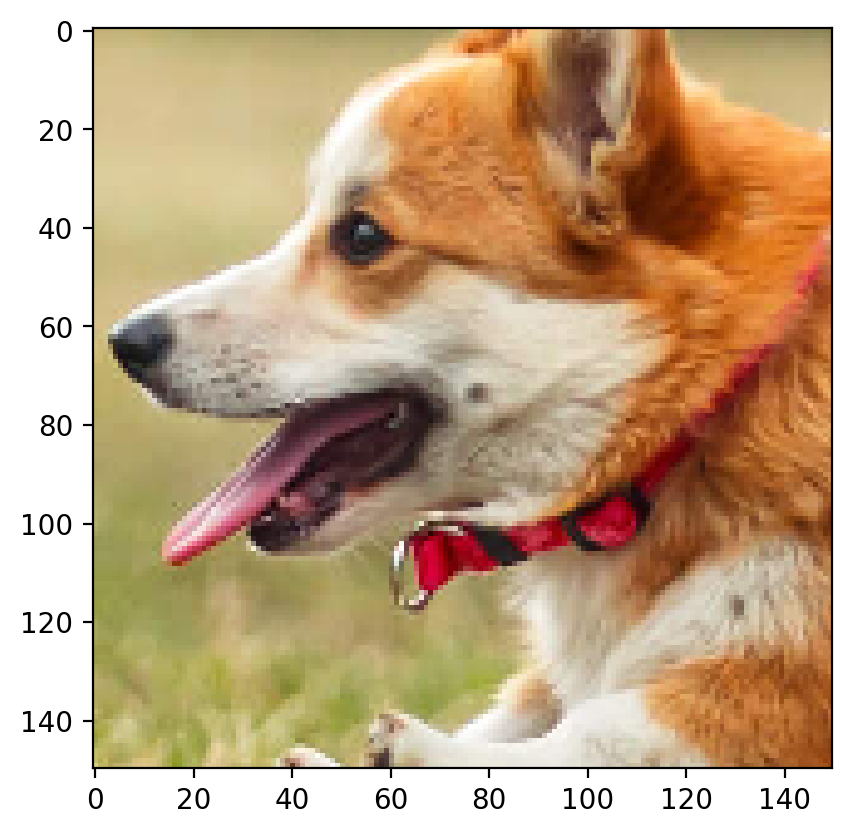

In [37]:
plt.imshow(rearrange(dog_alt_Y, '(h w) c -> h w c', h=int(np.sqrt(len(dog_alt_Y))), w=int(np.sqrt(len(dog_alt_Y)))).cpu().numpy())
plt.show()

In [38]:
X_alt_rff = create_rff_features(dog_alt_X, 6000, 0.08)


In [39]:
net = LinearModel(X_alt_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_alt_rff, dog_alt_Y, 1500)

Epoch 0 loss: 0.377767
Epoch 100 loss: 0.072653
Epoch 200 loss: 0.036119
Epoch 300 loss: 0.033459
Epoch 400 loss: 0.032944
Epoch 500 loss: 0.032620
Epoch 600 loss: 0.032392
Epoch 700 loss: 0.032230
Epoch 800 loss: 0.032116
Epoch 900 loss: 0.032036
Epoch 1000 loss: 0.031981
Epoch 1100 loss: 0.031942
Epoch 1200 loss: 0.031915
Epoch 1300 loss: 0.031896
Epoch 1400 loss: 0.031882


0.03187085688114166

In [40]:
reconstructed_image = net(X_alt_rff)
reconstructed_image = reconstructed_image.permute(1, 0).view(3, int(np.sqrt(len(reconstructed_image))), int(np.sqrt(len(reconstructed_image))))


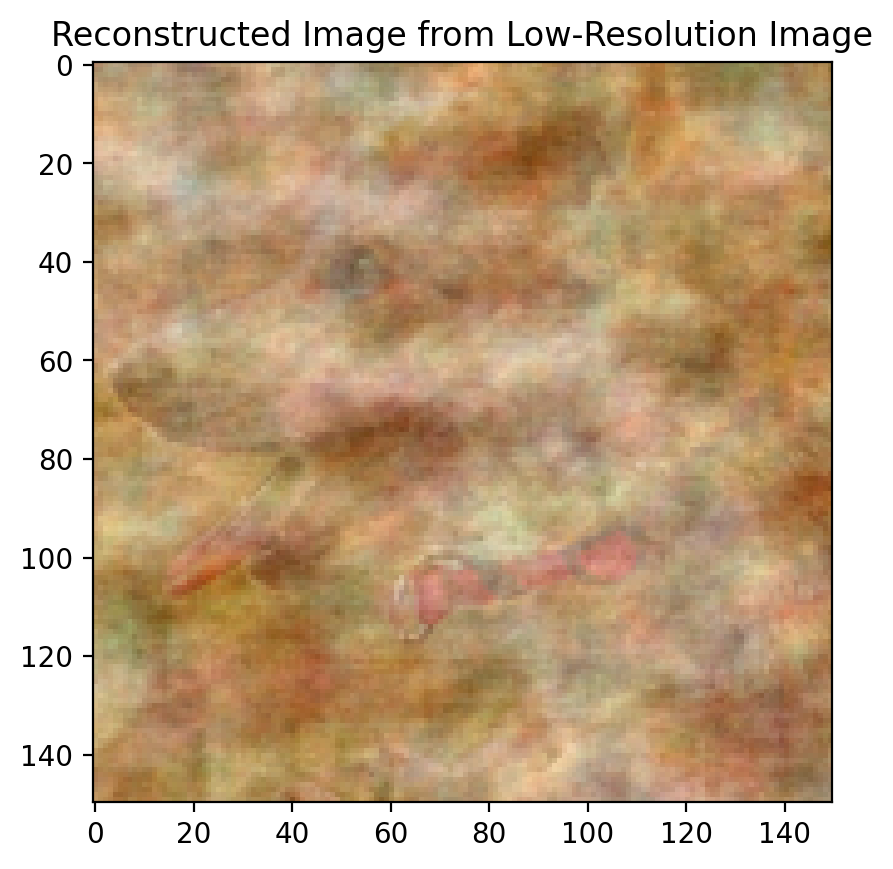

In [41]:
plt.imshow(rearrange(reconstructed_image.detach().cpu(), 'c h w -> h w c').numpy())
plt.title("Reconstructed Image from Low-Resolution Image")
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error
import math

reconstructed_image_cpu = reconstructed_image.cpu()

dog_re_X, dog_re_Y = create_coordinate_map(reconstructed_image_cpu)

dog_alt_Y_np = dog_alt_Y.cpu().detach().numpy().flatten()
dog_re_Y_np = dog_re_Y.cpu().detach().numpy().flatten()

mse = mean_squared_error(dog_alt_Y_np, dog_re_Y_np)
print("MSE:", mse)

max_pixel_value=1.0
psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))
print("PSNR:", psnr)

MSE: 0.03187076
PSNR: 14.966075797607425
